# Momentum Form Factor, Particle-In-A-Box (Evaluation)

This notebook evaluates the momentum form factors for the particle in a box model, of an electron confined to a box of size (4 a0, 7 a0, 10 a0), in units of the Bohr radius a0. The first example uses the transition from the ground state (nx=1, ny=1, nz=1) to the lowest-energy excited state, (nx=1, ny=1, nz=2). This simple form factor has a node at q_z=0, with maxima at |q_z| = 2.28 keV.

A second example tests a higher excited state, (nx=3, ny=2, nz=1), which has 

Demonstration of the adaptive integration method, with wavelet extrapolation.




In [1]:
import math
import numpy as np
import numba
# from numba import jit,cfunc
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr

sys.path.insert(0,'../') #load the local version of vsdm
# sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

# plt.rc('text', usetex=True)


'0.2.10'

In [2]:
### MOMENTUM DISTRIBUTION EXAMPLES

@numba.jit("double(int64,double)", nopython=True)
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus + s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly,
# so the lowest excited states are nz=2, nz=3, with nx=ny=1.

@numba.jit("double(double[:],int64,double[:])", nopython=True)
def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(double[:],int64[:],double[:])", nopython=True)
def fs2_nxyz(Lvec, n_xyz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    [nx, ny, nz] = n_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
    fx2 = fj2(nx, qLx)
    fy2 = fj2(ny, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(int64,double)", nopython=True)
def DeltaE_nz(nz, Lz):
    # for nx=ny=1 final states, in units of [q**2]/mElec
    return 0.5*math.pi**2 / mElec * (nz**2 - 1)/Lz**2

# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart(q_xyz):
    return fs2_nz(np.array([4/qBohr, 7/qBohr, 10/qBohr]), 2, q_xyz)

# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart_alt(q_xyz):
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    n_xyz = np.array([3, 2, 1])
    return fs2_nxyz(Lvec, n_xyz, q_xyz)


### Defining the function fs2(qSph) that ProjectFnlm will use as the input.
#   The function is decorated with symmetry identifiers (phi_even, phi_cyclic, etc)
#   This function is not a GaussianF instance, a sum of gaussians (is_gaussian==False) 

QMAX = 10*qBohr # Global value for q0=qMax for wavelets

# @numba.jit("double(double[:])", nopython=True)
def fs2_model4(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    return fs2_nz(Lvec, 2, q_xyz)
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2

def fs2_model4_alt(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    return fs2_model4_cart_alt(q_xyz)
fs2_model4_alt.is_gaussian = False
fs2_model4_alt.z_even = True
fs2_model4_alt.phi_even = True
fs2_model4_alt.phi_cyclic = 2



#

In [6]:
# Cartesian plots of the form factor
# XZ: at y=0
# YZ: at x=0
# XY_z0: at z=2.28 keV

n_rad = 400
avgQstep = QMAX / n_rad
print('average Qstep size: {:.4g} qBohr, {:.4g} keV'.format(avgQstep/qBohr, avgQstep/keV))

qmaxXY = 6*qBohr
qmaxZ = 2.5*qBohr
dq = 0.3 * avgQstep
qpmXY = np.array([i*dq for i in range(-int(qmaxXY/dq), int(qmaxXY/dq)+1)]) # q list 
qpmZ = np.array([i*dq for i in range(-int(qmaxZ/dq), int(qmaxZ/dq)+1)]) # q list 

qXZlist = np.array([[(qx, 0, -qz) for qx in qpmXY] for qz in qpmZ])
qYZlist = np.array([[(0, qy, -qz) for qy in qpmXY] for qz in qpmZ])
qXYlist = np.array([[(qx, -qy, 0) for qx in qpmXY] for qy in qpmXY])
qXYlist_z0 = np.array([[(qx, -qy, 2.28*keV) for qx in qpmXY] for qy in qpmXY])

Nx = len(qpmXY)
Ny = len(qpmXY)
Nz = len(qpmZ)

fm4_xz = {}
fm4_yz = {}
fm4_xy = {}

# fm4_xz['exact'] = np.array([[fs2_model4_cart(qXZlist[iz,ix]) 
#                              for ix in range(Nx)] for iz in range(Nz)])
# fm4_yz['exact'] = np.array([[fs2_model4_cart(qYZlist[iz,iy]) 
#                              for iy in range(Ny)] for iz in range(Nz)])
# fm4_xy['exact'] = np.array([[fs2_model4_cart(qXYlist_z0[iy,ix]) 
#                              for ix in range(Nx)] for iy in range(Ny)])


average Qstep size: 0.025 qBohr, 0.09322 keV


## Higher excited state: (1, 2, 3)

In [7]:
# Cartesian plots of the form factor

# New Choices for x0, y0, z0 planes:
qx0 = 8.73*keV
qy0 = 3.25*keV
qz0 = 0.0*keV

qXZlist = np.array([[(qx, qy0, -qz) for qx in qpmXY] for qz in qpmZ])
qYZlist = np.array([[(qx0, qy, -qz) for qy in qpmXY] for qz in qpmZ])
qXYlist = np.array([[(qx, -qy, qz0) for qx in qpmXY] for qy in qpmXY])

fm4_xz['alt'] = np.array([[fs2_model4_cart_alt(qXZlist[iz,ix]) 
                           for ix in range(Nx)] for iz in range(Nz)])
fm4_yz['alt'] = np.array([[fs2_model4_cart_alt(qYZlist[iz,iy]) 
                           for iy in range(Ny)] for iz in range(Nz)])
fm4_xy['alt'] = np.array([[fs2_model4_cart_alt(qXYlist[iy,ix]) 
                           for ix in range(Nx)] for iy in range(Ny)])


In [8]:
max_xy_alt = np.max(fm4_xy['alt'])
max_xz_alt = np.max(fm4_xz['alt'])
max_yz_alt = np.max(fm4_yz['alt'])
max_z_alt = np.max([max_xz_alt, max_yz_alt, max_xy_alt])
print(max_z_alt)

0.19813852277017974


In [9]:
qmax = 10*qBohr
dq = 0.01*qBohr
qs = np.array([i*dq for i in range(int(qmax/dq)+1)]) # |q| list 
q_keV = np.array([q/keV for q in qs])

# qx0 = 9*keV
# qy0 = 4*keV
# qz0 = 0*keV

qxs = np.array([(qx, qy0, qz0) for qx in qs])
qys = np.array([(qx0, qy, qz0) for qy in qs])
qzs = np.array([(qx0, qy0, qz) for qz in qs])

fx1 = np.array([fs2_model4_cart_alt(q) for q in qxs])
fy1 = np.array([fs2_model4_cart_alt(q) for q in qys])
fz1 = np.array([fs2_model4_cart_alt(q) for q in qzs])


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_34736/670497.py:76: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmapXY,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_34736/670497.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


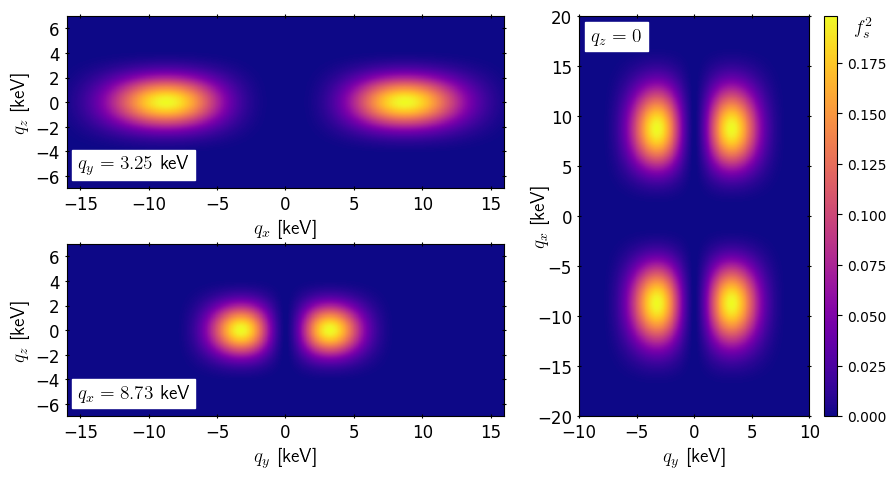

In [10]:
unisize = 2.5
fig = plt.figure(figsize=[unisize,unisize])
x0 = 1.0
dx0 = 0.3
dy0 = 0.07
y0 = 1.6
x2 = 1.75
fonts = 14
labels = 12
colorXY = 'plasma'
colorZ = 'plasma'

qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
zylim = [-7,7]
ztix = [-6, -4, -2, 0, 2, 4, 6]

ayz = fig.add_axes([0,0,x2,(0.5 - dy0)*y0], xscale='linear', yscale='linear')
ayz.pcolormesh(qXY_keV, qZ_keV, fm4_yz['alt'], shading='nearest', cmap=colorZ)
ayz.set_xlim([-16, 16])
ayz.set_ylim(zylim)
ayz.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
ayz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ayz.set_yticks(ztix)
ayz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ayz.text(0.025, 0.08, r'$q_x=8.73$ keV', horizontalalignment='left',
         verticalalignment='bottom', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ayz.transAxes, usetex=True)

axz = fig.add_axes([0,(0.5+dy0)*y0,x2,(0.5 - dy0)*y0], xscale='linear', yscale='linear')
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz['alt'], shading='nearest', cmap=colorZ)
axz.set_xlim([-16, 16])
axz.set_ylim(zylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
axz.set_yticks(ztix)
axz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
axz.text(0.025, 0.08, r'$q_y=3.25$ keV', horizontalalignment='left',
         verticalalignment='bottom', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axz.transAxes, usetex=True)

cnormZ = plt.Normalize(vmin=0, vmax=max_z_alt)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=colorZ)


axy = fig.add_axes([x2+dx0,0,1.15*x0,y0], 
                   xscale='linear', yscale='linear')
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy['alt'].transpose(), shading='nearest', cmap=colorXY)
axy.set_ylim([-20, 20])
axy.set_xlim( [-10, 10])
axy.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
axy.set_ylabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axy.yaxis.set_label_position('left')
axy.yaxis.set_label_coords(-0.13,0.5)
axy.set_xticks([-10, -5, 0, 5, 10])
axy.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)
axy.text(0.05, 0.97, r'$q_z=0$', horizontalalignment='left',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axy.transAxes, usetex=True)
axy.text(1.235, 1.00, r'$f_s^2$', horizontalalignment='center',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axy.transAxes, usetex=True)

cnormXY = plt.Normalize(vmin=0, vmax=max_z_alt)
clmapXY = plt.cm.ScalarMappable(norm=cnormXY, cmap=colorXY)

fig.colorbar(mappable=clmapXY, 
             orientation='vertical', location='right', 
             aspect=30)

plt.savefig('out/fs2_xyz_alt.png', format="png", dpi=300, bbox_inches='tight')

fig.show()

## Ray plots

In [11]:
qmax = 10*qBohr
dq = 0.01*qBohr
qs = np.array([i*dq for i in range(int(qmax/dq)+1)]) # |q| list 
q_keV = np.array([q/keV for q in qs])

qxs = np.array([(qx, qy0, qz0) for qx in qs])
qys = np.array([(qx0, qy, qz0) for qy in qs])
qzs = np.array([(qx0, qy0, qz) for qz in qs])

fx1 = np.array([fs2_model4_cart_alt(q) for q in qxs])
fy1 = np.array([fs2_model4_cart_alt(q) for q in qys])
fz1 = np.array([fs2_model4_cart_alt(q) for q in qzs])


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_34736/4250724309.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


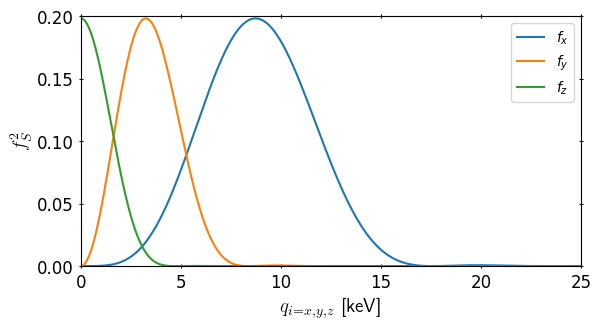

In [12]:
fig = plt.figure(figsize=[2*unisize,unisize])
ax4 = fig.add_axes([0,0,1,1], 
                   xscale='linear', yscale='linear')
# ax4.plot(q_keV, fx1, q_keV, fy1, q_keV, fz1)
ax4.plot(q_keV, fx1, label=r'$f_x$')
ax4.plot(q_keV, fy1, label=r'$f_y$')
ax4.plot(q_keV, fz1, label=r'$f_z$')

ax4.set_xlim([0, 25])
ax4.set_ylim([0, 0.2])
ax4.set_xlabel(r'$q_{i=x,y,z}$ [keV]', fontsize=fonts, usetex=True)
ax4.set_ylabel(r'$f_S^2$', fontsize=fonts, usetex=True)
ax4.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)
ax4.legend(loc='upper right')

fig.show()

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_34736/2869180679.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


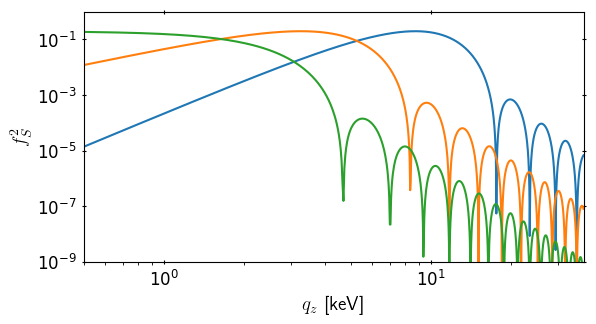

In [13]:
fig = plt.figure(figsize=[2*unisize,unisize])
ax4 = fig.add_axes([0,0,1,1], 
                   xscale='log', yscale='log')
ax4.plot(q_keV, fx1, q_keV, fy1, q_keV, fz1)
ax4.set_xlim([0.5, qmax/keV])
ax4.set_ylim([1e-9, 1])
ax4.set_xlabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ax4.set_ylabel(r'$f_S^2$', fontsize=fonts, usetex=True)
ax4.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)

fig.show()

# Numerical Results
### Reading coeffs from data... (See end of notebook for numerical evaluation)


In [14]:
bdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)
epsilon = 1e-8
energy_est = 0.00035
atol_E = energy_est * epsilon
atol_f = 0.05 * math.sqrt(atol_E)
integ_params = dict(method='gquad', verbose=True, rtol_f=epsilon, atol_f=atol_f)

# # Read Fnlm from saved CSV file...

csvname = 'demo/fs2_box_4_7_10_alt.csv'


wave_csv = vsdm.WaveletFnlm(bdict, fs2_model4_alt, integ_params,
                            power2_lm={}, p_order=3,
                            epsilon=epsilon,
                            atol_energy=atol_E,
                            atol_fnlm=atol_f,
                            max_depth=5,
                            refine_at_init=False,
                            f_type='fs2',
                            csvsave_name=None,
                            use_gvar=False)
wave_csv.importFnlm_csv(csvname)


In [15]:
print(wave_csv.nMax, wave_csv.ellMax)
print('nCoeffs = {}'.format(len(wave_csv.f_nlm.keys())))

1023 36
nCoeffs = 194560


In [16]:
"""Direct calculation of norm"""
t0 = time.time()
totalEnergy = wave_csv.getDistEnergy(integ_params)
tEnergyInt = time.time() - t0
print(totalEnergy)

0.000025307(93)
energy: 0.00010123(37)
0.00010123(37)


In [17]:
fnlm2sum = wave_csv.f2nlm_energy()
print(fnlm2sum)

0.00010122865926736352


In [18]:
f000 = wave_csv.f_nlm[(0,0,0)]
f000_check = wave_csv.getFnlm(fs2_model4_alt, (0,0,0), integ_params)
print(f000, f000_check)

Calculating <f|nlm> for nlm: (0, 0, 0)
0.000162315(93)
0.0006492585927060722 0.00064926(37)


## Heat Plots (From Numerics)

Note: the 2d heat plots can take a long time to evaluate, especially when large numbers of coefficients are included in the inverse wavelet transformation.

In [19]:
avgQstep = QMAX / wave_csv.nMax
print('average Qstep size (in qBohr):', avgQstep/qBohr)

# New Choices for x0, y0, z0 planes:
qx0 = 8.73*keV
qy0 = 3.25*keV
qz0 = 0.0*keV

qmaxXY = 6*qBohr
qmaxZ = 2.5*qBohr
dq = 0.3 * avgQstep
qpmXY = np.array([i*dq for i in range(-int(qmaxXY/dq), int(qmaxXY/dq)+1)]) # q list 
qpmZ = np.array([i*dq for i in range(-int(qmaxZ/dq), int(qmaxZ/dq)+1)]) # q list 

qXZlist = np.array([[(qx, qy0, -qz) for qx in qpmXY] for qz in qpmZ])
qYZlist = np.array([[(qx0, qy, -qz) for qy in qpmXY] for qz in qpmZ])
qXYlist = np.array([[(qx, -qy, qz0) for qx in qpmXY] for qy in qpmXY])

# fm4_xz['alt'] = np.array([[fs2_model4_cart_alt(qXZlist[iz,ix]) 
#                            for ix in range(Nx)] for iz in range(Nz)])
# fm4_yz['alt'] = np.array([[fs2_model4_cart_alt(qYZlist[iz,iy]) 
#                            for iy in range(Ny)] for iz in range(Nz)])
# fm4_xy['alt'] = np.array([[fs2_model4_cart_alt(qXYlist[iy,ix]) 
#                            for ix in range(Nx)] for iy in range(Ny)])




average Qstep size (in qBohr): 0.009775171065493646


In [20]:
nlm_ordered = [nlm for nlm in getNLMpower(wave_csv.f_nlm).keys()]
print('ncoeffs:', len(nlm_ordered))
f_nlm_100 = {}
f_nlm_300 = {}
f_nlm_1000 = {}
f_nlm_all = {}
ix = 0
for nlm in nlm_ordered:
    fnlm = wave_csv.f_nlm[nlm]
    if ix < 100:
        f_nlm_100[nlm] = fnlm
    if ix < 300:
        f_nlm_300[nlm] = fnlm
    if ix < 1000:
        f_nlm_1000[nlm] = fnlm
    f_nlm_all[nlm] = fnlm
    ix += 1
# gvar-less f_nlm for speed
# u_eg = (2.5*qBohr, 0.3*np.pi, 1.2*np.pi)
# print(wave_csv.nlmAssembleFu(f_nlm_all, u_eg))

ncoeffs: 194560


## Extrapolation for interpolation...

In [21]:
lm_lists = {100:[], 300:[], 1000:[]}
nmaxes = {100:0, 300:0, 1000:0}
for (n,l,m) in f_nlm_100:
    if n > nmaxes[100]:
        nmaxes[100] = n
    if (l, m) not in lm_lists[100]:
        lm_lists[100] += [(l, m)]

for (n,l,m) in f_nlm_300:
    if n > nmaxes[300]:
        nmaxes[300] = n
    if (l, m) not in lm_lists[300]:
        lm_lists[300] += [(l, m)]

for (n,l,m) in f_nlm_1000:
    if n > nmaxes[1000]:
        nmaxes[1000] = n
    if (l, m) not in lm_lists[1000]:
        lm_lists[1000] += [(l, m)]

print(nmaxes[100], nmaxes[300], nmaxes[1000])

power2 = {}
for j in [100, 300, 1000]:
    power2[j] = int(np.ceil(np.log2(nmaxes[j]+1)))
# wave_csv, f_nlm_100 
print(power2)
# print(lm_lists)

20 43 171
{100: 5, 300: 6, 1000: 8}


In [22]:
extp_0 = {}
for j in [100, 300, 1000]:
    extp_0[j] = vsdm.WaveletFnlm(bdict, fs2_model4_alt, integ_params,
                                 power2_lm={}, p_order=0,
                                 epsilon=epsilon,
                                 atol_energy=atol_E,
                                 atol_fnlm=atol_f,
                                 max_depth=1,
                                 refine_at_init=False,
                                 f_type='fs2',
                                 csvsave_name=None,
                                 use_gvar=False)
    for lm in lm_lists[j]:
        for n in range(2**power2[j]):
            nlm = (n, lm[0], lm[1])
            extp_0[j].f_nlm[nlm] = 0.
        # extp_0[j].initialize_lm(lm, power2[j])

In [23]:
extp_1 = {}
for j in [100, 300, 1000]:
    extp_1[j] = vsdm.WaveletFnlm(bdict, fs2_model4_alt, integ_params,
                                 power2_lm={}, p_order=1,
                                 epsilon=epsilon,
                                 atol_energy=atol_E,
                                 atol_fnlm=atol_f,
                                 max_depth=1,
                                 refine_at_init=False,
                                 f_type='fs2',
                                 csvsave_name=None,
                                 use_gvar=False)
    for lm in lm_lists[j]:
        for n in range(2**power2[j]):
            nlm = (n, lm[0], lm[1])
            extp_1[j].f_nlm[nlm] = 0.


In [24]:
extp_3 = {}
for j in [100, 300, 1000]:
    extp_3[j] = vsdm.WaveletFnlm(bdict, fs2_model4_alt, integ_params,
                                 power2_lm={}, p_order=3,
                                 epsilon=epsilon,
                                 atol_energy=atol_E,
                                 atol_fnlm=atol_f,
                                 max_depth=1,
                                 refine_at_init=False,
                                 f_type='fs2',
                                 csvsave_name=None,
                                 use_gvar=False)
    for lm in lm_lists[j]:
        for n in range(2**power2[j]):
            nlm = (n, lm[0], lm[1])
            extp_3[j].f_nlm[nlm] = 0.


In [25]:
j = 100
for nlm in f_nlm_100:
    fnlm = wave_csv.f_nlm[nlm]
    extp_0[j].f_nlm[nlm] = fnlm
    extp_1[j].f_nlm[nlm] = fnlm
    extp_3[j].f_nlm[nlm] = fnlm
    
j = 300
for nlm in f_nlm_300:
    fnlm = wave_csv.f_nlm[nlm]
    extp_0[j].f_nlm[nlm] = fnlm
    extp_1[j].f_nlm[nlm] = fnlm
    extp_3[j].f_nlm[nlm] = fnlm
    
j = 1000
for nlm in f_nlm_1000:
    fnlm = wave_csv.f_nlm[nlm]
    extp_0[j].f_nlm[nlm] = fnlm
    extp_1[j].f_nlm[nlm] = fnlm
    extp_3[j].f_nlm[nlm] = fnlm

for j in [100, 300, 1000]:
    for lm in lm_lists[j]:
        extp_0[j].initialize_lm(lm, power2[j])
        extp_1[j].initialize_lm(lm, power2[j])
        extp_3[j].initialize_lm(lm, power2[j])        
#

In [26]:
extp_0[100](cart_to_sph(qXZlist[20,20]))

0.00024179409991396215

In [46]:
Nx = len(qpmXY)
Ny = len(qpmXY)
Nz = len(qpmZ)
flabels = [100, 300, 1000]
print(Nx, Ny, Nz)

4093 4093 1705


In [47]:
t0 = time.time()

fm4_xz = {}
for j in flabels:
    fm4_xz[(0,j)] = np.array([[extp_0[j](cart_to_sph(qXZlist[iz,ix])) 
                             for ix in range(Nx)] for iz in range(Nz)])
    np.savetxt('temp/fXZ_{}_{}.csv'.format(0, j), fm4_xz[(0,j)], delimiter=',')
    print('Completed {}. teval = {}'.format(j, time.time()-t0))

t_plot_xz = time.time() - t0
print(t_plot_xz)

Completed 100. teval = 391.54484391212463
Completed 300. teval = 1174.004676103592
Completed 1000. teval = 3419.500836133957
3419.541547060013


In [29]:
t0 = time.time()
fm4_yz = {}

for j in flabels:
    fm4_yz[(0,j)] = np.array([[extp_0[j](cart_to_sph(qYZlist[iz,iy])) 
                               for iy in range(Ny)] for iz in range(Nz)])
    np.savetxt('temp/fYZ_{}_{}.csv'.format(0, j), fm4_yz[(0,j)], delimiter=',')
    print('Completed {}. teval = {:.4g} s'.format(j, time.time()-t0))

t_plot_yz = time.time() - t0
print(t_plot_yz)

Completed 100. teval = 404 s
Completed 300. teval = 1218 s
Completed 1000. teval = 3947 s
3946.6017649173737


In [30]:
t0 = time.time()
fm4_xy = {}

for j in flabels:
    fm4_xy[(0,j)] = np.array([[extp_0[j](cart_to_sph(qXYlist[iy,ix])) 
                               for ix in range(Nx)] for iy in range(Ny)])
    np.savetxt('temp/fXY_{}_{}.csv'.format(0, j), fm4_xy[(0,j)], delimiter=',')
    print('Completed {}. teval = {:.4g} s'.format(j, time.time()-t0))

t_plot_xy = time.time() - t0
print(t_plot_xy)

Completed 100. teval = 1002 s
Completed 300. teval = 2998 s
Completed 1000. teval = 9212 s
9212.06290102005


In [31]:
t0 = time.time()
for j in flabels:
    fm4_xz[(1,j)] = np.array([[extp_1[j](cart_to_sph(qXZlist[iz,ix])) 
                             for ix in range(Nx)] for iz in range(Nz)])
    np.savetxt('temp/fXZ_{}_{}.csv'.format(1, j), fm4_xz[(1,j)], delimiter=',')
    fm4_yz[(1,j)] = np.array([[extp_1[j](cart_to_sph(qYZlist[iz,iy])) 
                               for iy in range(Ny)] for iz in range(Nz)])
    np.savetxt('temp/fYZ_{}_{}.csv'.format(1, j), fm4_yz[(1,j)], delimiter=',')
    fm4_xy[(1,j)] = np.array([[extp_1[j](cart_to_sph(qXYlist[iy,ix])) 
                               for ix in range(Nx)] for iy in range(Ny)])
    np.savetxt('temp/fXY_{}_{}.csv'.format(1, j), fm4_xy[(1,j)], delimiter=',')
    print('Completed linear {}. teval = {}'.format(j, time.time()-t0))


Completed linear 100. teval = 1735.3965179920197
Completed linear 300. teval = 5277.177189826965
Completed linear 1000. teval = 16132.103451013565


In [32]:
t0 = time.time()
for j in flabels:
    fm4_xz[(3,j)] = np.array([[extp_3[j](cart_to_sph(qXZlist[iz,ix])) 
                             for ix in range(Nx)] for iz in range(Nz)])
    np.savetxt('temp/fXZ_{}_{}.csv'.format(3, j), fm4_xz[(3,j)], delimiter=',')
    fm4_yz[(3,j)] = np.array([[extp_3[j](cart_to_sph(qYZlist[iz,iy])) 
                               for iy in range(Ny)] for iz in range(Nz)])
    np.savetxt('temp/fYZ_{}_{}.csv'.format(3, j), fm4_yz[(3,j)], delimiter=',')
    fm4_xy[(3,j)] = np.array([[extp_3[j](cart_to_sph(qXYlist[iy,ix])) 
                               for ix in range(Nx)] for iy in range(Ny)])
    np.savetxt('temp/fXY_{}_{}.csv'.format(3, j), fm4_xy[(3,j)], delimiter=',')
    print('Completed cubic {}. teval = {}'.format(j, time.time()-t0))


Completed cubic 100. teval = 2059.089334011078
Completed cubic 300. teval = 5851.407972812653
Completed cubic 1000. teval = 14294.479340076447


In [ ]:
# for j in flabels:
#     # fm4_xz[(0,j)] = np.genfromtxt('temp/fXZ_{}_{}.csv'.format(0, j), delimiter=",")
#     fm4_xz[(0,j)] = fm4_xz[(1,j)]

# #

In [50]:
f_nlm_10000 = {}
ix = 0
for nlm in nlm_ordered:
    fnlm = wave_csv.f_nlm[nlm]
    if ix < 10000:
        f_nlm_10000[nlm] = fnlm
    else:
        break
    ix += 1
    
lm_lists[10000] = []
nmaxes[10000] = 0
for (n,l,m) in f_nlm_10000:
    if n > nmaxes[10000]:
        nmaxes[10000] = n
    if (l, m) not in lm_lists[10000]:
        lm_lists[10000] += [(l, m)]
power2[10000] = int(np.ceil(np.log2(nmaxes[10000]+1)))
print(nmaxes[10000])
print(power2)


727
{100: 5, 300: 6, 1000: 8, 10000: 10}


In [51]:
for j in [10000]:
    extp_0[j] = vsdm.WaveletFnlm(bdict, fs2_model4_alt, integ_params,
                                 power2_lm={}, p_order=0,
                                 epsilon=epsilon,
                                 atol_energy=atol_E,
                                 atol_fnlm=atol_f,
                                 max_depth=1,
                                 refine_at_init=False,
                                 f_type='fs2',
                                 csvsave_name=None,
                                 use_gvar=False)
    for lm in lm_lists[j]:
        for n in range(2**power2[j]):
            nlm = (n, lm[0], lm[1])
            extp_0[j].f_nlm[nlm] = 0.


In [55]:
j = 10000
for nlm in f_nlm_10000:
    fnlm = wave_csv.f_nlm[nlm]
    extp_0[j].f_nlm[nlm] = fnlm
    # extp_1[j].f_nlm[nlm] = fnlm
    # extp_3[j].f_nlm[nlm] = fnlm

for lm in lm_lists[j]:
    extp_0[j].initialize_lm(lm, power2[j])
    # extp_1[j].initialize_lm(lm, power2[j])
    # extp_3[j].initialize_lm(lm, power2[j])        


In [56]:
for j in [10000]:
    t0 = time.time()
    fm4_xz[(0,j)] = np.array([[extp_0[j](cart_to_sph(qXZlist[iz,ix])) 
                             for ix in range(Nx)] for iz in range(Nz)])
    np.savetxt('temp/fXZ_{}_{}.csv'.format(0, j), fm4_xz[(0,j)], delimiter=',')
    print('Completed XZ {}. teval = {}'.format(j, time.time()-t0))
    fm4_yz[(0,j)] = np.array([[extp_0[j](cart_to_sph(qYZlist[iz,iy])) 
                               for iy in range(Ny)] for iz in range(Nz)])
    np.savetxt('temp/fYZ_{}_{}.csv'.format(0, j), fm4_yz[(0,j)], delimiter=',')
    print('Completed YZ {}. teval = {}'.format(j, time.time()-t0))
    fm4_xy[(0,j)] = np.array([[extp_0[j](cart_to_sph(qXYlist[iy,ix])) 
                               for ix in range(Nx)] for iy in range(Ny)])
    np.savetxt('temp/fXY_{}_{}.csv'.format(0, j), fm4_xy[(0,j)], delimiter=',')
    print('Completed all {}. teval = {}'.format(j, time.time()-t0))


Completed XZ 10000. teval = 11866.513679981232
Completed YZ 10000. teval = 25734.54254412651
Completed all 10000. teval = 60789.264146089554


In [58]:
np.shape(fm4_xz[(0,10000)])

(1705, 4093)

In [45]:
np.shape(fm4_xz[(1,100)])

(1705, 4093)

TypeError: Dimensions of C (667, 1601) are incompatible with X (4093) and/or Y (1705); see help(pcolormesh)

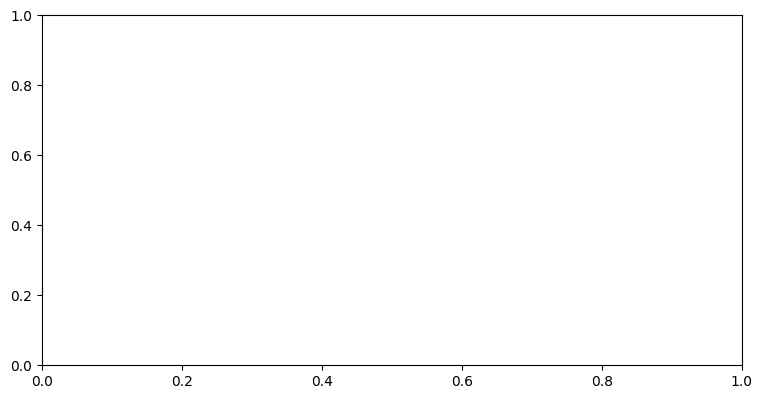

In [42]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-8, 8]
fig = plt.figure(figsize=[2.0*unisize,unisize])
axz = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz[(0, 1000)], shading='nearest', cmap='inferno')
axz.set_xlim(xlim)
axz.set_ylim(ylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=13, usetex=True)

fig.show()